In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.signal import find_peaks

data_path = "../data"

In [2]:
print(len("2020-01-05T19:02:35.000Z"))
from datetime import datetime
import dateutil.parser

def dateparse(x):
    return dateutil.parser.isoparse(x)
# dateparse("2020-01-05T19:02:35.000Z")
article_df = pd.read_csv(
    f"{data_path}/2020_articles.csv",
    parse_dates=["date_published"], 
#     date_parser=dateparse
)
print(article_df.shape)
article_df = article_df[article_df.num_tweets > 1]
article_df.set_index("id")
article_df['date_published']


# article_ids = []
# with open("../data/article_ids.csv", "r") as f:
#     for aid in f.readlines():
#         article_ids.append(aid.rstrip())
# print(article_ids)
        
# article_df = pd.read_csv(f"{data_path}/all_articles.csv")
# article_df['date_published']= pd.to_datetime(article_df['date_published'])
# print(f"Total articles: {article_df.shape[0]}")
# article_df = article_df[article_df["id"].isin(article_ids)]
# article_df.to_csv(f"{data_path}/article_features.csv")
# print(f"Total articles: {article_df.shape[0]}")
# article_df.head()

24
(3889, 9)


0      2020-01-05 19:02:35+00:00
1      2020-01-07 15:23:14+00:00
2      2020-01-01 04:35:24+00:00
3      2020-01-03 01:20:23+00:00
4      2020-01-02 05:00:00+00:00
                  ...           
3884   2020-11-07 20:07:08+00:00
3885   2020-11-07 18:51:32+00:00
3886   2020-11-06 01:27:39+00:00
3887   2020-11-06 08:01:52+00:00
3888   2020-11-07 19:46:02+00:00
Name: date_published, Length: 2969, dtype: datetime64[ns, UTC]

In [3]:
article_feature_df = pd.read_csv(
    f"{data_path}/article_features.csv",
    parse_dates=["date_published"],
).iloc[:, 1:].drop_duplicates(["id"], ignore_index=True)
article_feature_df.set_index("id")
print(article_feature_df.shape)
article_feature_df.sort_values("num_peaks", ascending=False).head()

(297, 14)


,id,title,date_published,which_half,url,domain,num_tweets,score,site_type,num_peaks,active_days,lifespan,active_ratio,avg_peak_dist
52,1794041,DOJ: Democrats Paid Pennsylvania Election Offi...,2020-05-21 17:15:16+00:00,1,https://www.breitbart.com/politics/2020/05/21/...,breitbart.com,80250,88.265755,claim,7,148,190,0.778947,30.500000
101,1879125,New Jersey Democrats Charged with Mail-In Vote...,2020-06-28 23:20:02+00:00,1,https://www.breitbart.com/politics/2020/06/28/...,breitbart.com,8192,7.931287,claim,5,118,152,0.776316,24.750000
91,1858904,Trump's Absentee vs. Mail-In Ballot Spin,2020-06-19 10:02:00+00:00,1,https://www.factcheck.org/2020/06/trumps-absen...,factcheck.org,2489,102.543686,fact_checking,4,103,161,0.639752,18.000000
146,1988227,How to make sure your ballot is counted this fall,2020-08-17 04:00:00+00:00,2,https://www.politifact.com/article/2020/aug/17...,politifact.com,600,98.936340,fact_checking,4,20,78,0.256410,12.666667
10,1698377,Trump's Latest Voter Fraud Misinformation,2020-04-10 14:17:59+00:00,1,https://www.factcheck.org/2020/04/trumps-lates...,factcheck.org,2787,9.210379,fact_checking,4,181,231,0.783550,35.666667


In [4]:
# grouped_df = time_tweet_df.groupby(["date", "type"]).count()["id"].unstack("type").fillna(0)
# grouped_df.plot.bar(title="Tweet Volume over Time", figsize=(12,8), stacked=True);
article_feature_df.groupby(["which_half", "num_peaks"]).agg({
    "lifespan": "mean", 
    "active_days": "mean", 
    "active_ratio": "mean", 
    "id": "count",
})

lifespan  active_days  active_ratio   id
which_half num_peaks                                            
1          0          118.625000    29.625000      0.525129    8
           1           78.411111    14.744444      0.368670   90
           2          172.090909    52.181818      0.311277   11
           3          220.500000   140.000000      0.645827    2
           4          196.000000   142.000000      0.711651    2
           5          152.000000   118.000000      0.776316    1
           7          190.000000   148.000000      0.778947    1
2          0           45.307692    16.461538      0.616054   13
           1           27.798742     8.937107      0.548666  159
           2           47.428571    18.000000      0.541972    7
           3          100.500000    44.500000      0.471653    2
           4           78.000000    20.000000      0.256410    1

In [5]:
article_feature_df[article_feature_df.num_peaks > 1].groupby(["which_half"]).agg({
    "lifespan": "mean", 
    "num_peaks": "mean",
    "active_days": "mean", 
    "active_ratio": "mean", 
    "avg_peak_dist": "mean",
    "id": "count",
})

,lifespan,num_peaks,active_days,active_ratio,avg_peak_dist,id
which_half,,,,,,
1,180.470588,2.823529,82.588235,0.452604,48.259804,17
2,61.100000,2.400000,23.500000,0.499352,27.766667,10


### Peaks Analysis

In [6]:
peaks_df = pd.read_csv("../data/article_peaks.csv").iloc[:,1:]
peaks_df.peak_date = pd.to_datetime(peaks_df.peak_date)
peaks_df["year"] = peaks_df.peak_date.dt.year
peaks_df["month"] = peaks_df.peak_date.dt.month
peaks_df["day"] = peaks_df.peak_date.dt.day
peaks_df.sort_values("peak_height", ascending=False).head()

,aid,peak_date,peak_height,year,month,day
2,2168163,2020-11-05,80968.0,2020,11,5
0,2176377,2020-11-08,57754.0,2020,11,8
172,1794041,2020-05-21,38570.0,2020,5,21
182,1863303,2020-06-22,25013.0,2020,6,22
179,1680451,2020-04-04,19446.0,2020,4,4


In [7]:
peaks_df = peaks_df[peaks_df.year >= 2020]
by_month_df = peaks_df.groupby("month").agg({"aid": "count", "peak_height": "sum"})
by_month_df.sort_values("peak_height", ascending=False)

,aid,peak_height
month,,
11,59,173523.0
5,51,64866.0
6,26,50710.0
4,33,37365.0
9,45,27082.0
8,37,26731.0
10,43,24590.0
7,24,15126.0
3,5,5053.0


<AxesSubplot:title={'center':'Cumulative Peak Height (2020)'}, xlabel='month', ylabel='# of Tweets'>

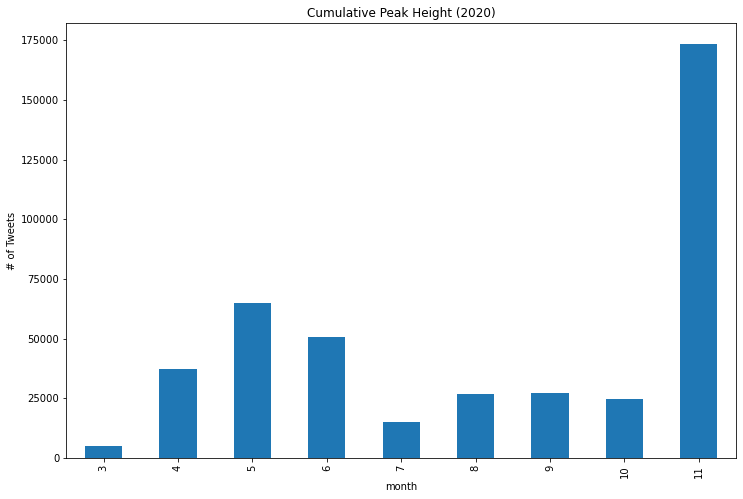

In [8]:
by_month_df["peak_height"].plot.bar(
    title="Cumulative Peak Height (2020)", 
    ylabel="# of Tweets", 
    figsize=(12,8)
)

<AxesSubplot:title={'center':'Log Cumulative Peak Height (2020)'}, xlabel='month', ylabel='# of Tweets (log scale)'>

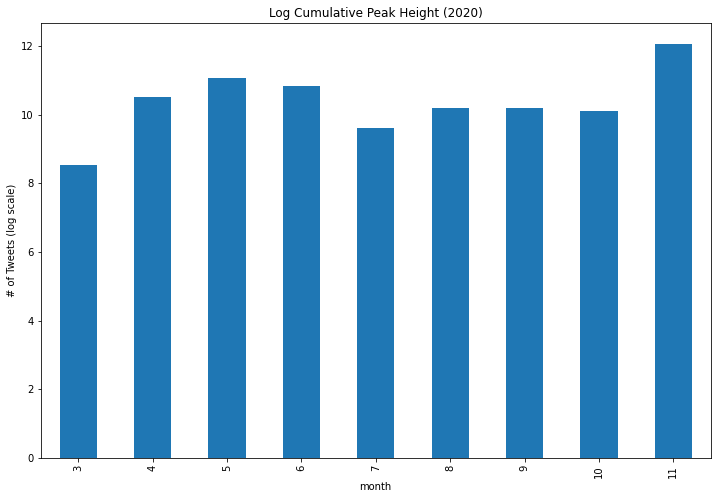

In [9]:
log_by_month_df = by_month_df.copy()
log_by_month_df["log_height"] = np.log(log_by_month_df.peak_height)
log_by_month_df["log_height"].plot.bar(
    title="Log Cumulative Peak Height (2020)", 
    ylabel="# of Tweets (log scale)", 
    figsize=(12,8)
)

<AxesSubplot:title={'center':'Cumulative Peak Height (November)'}, xlabel='day', ylabel='# of Tweets'>

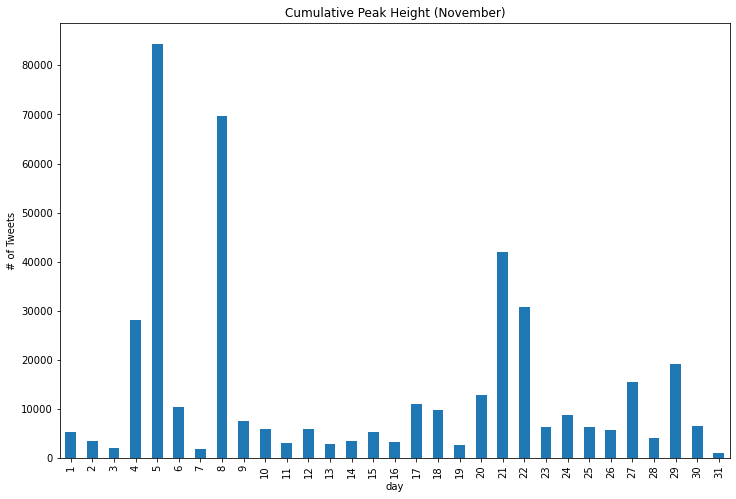

In [10]:
nov_peaks_df = peaks_df[peaks_df.month == 11]
nov_peaks_df = peaks_df.groupby("day").agg({"aid": "count", "peak_height": "sum"})
nov_peaks_df["peak_height"].plot.bar(
    title="Cumulative Peak Height (November)", 
    ylabel="# of Tweets", 
    figsize=(12,8)
)

In [11]:
feature_peaks_df = peaks_df.join(article_feature_df.set_index("id"), on="aid", how="left")

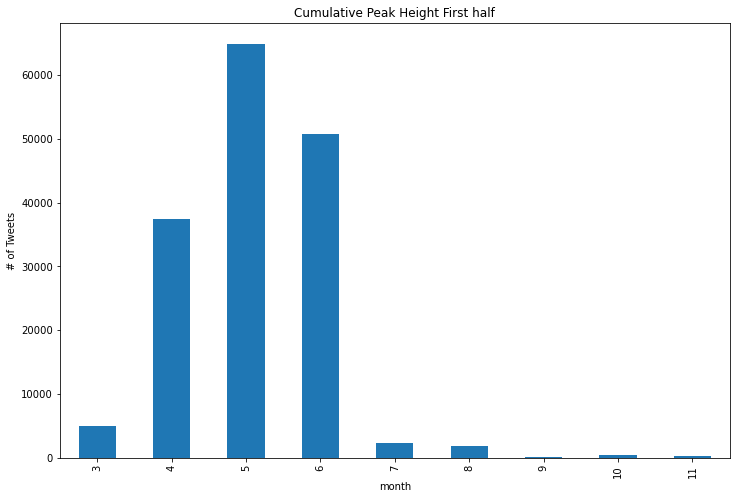

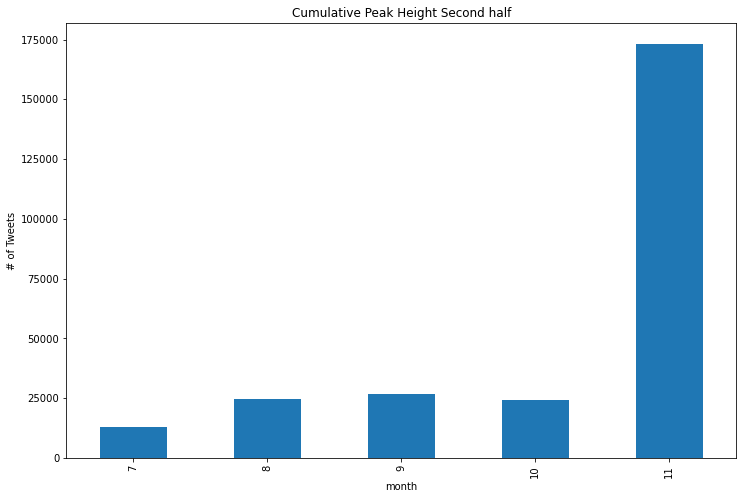

In [12]:
fp_half1_df = feature_peaks_df[feature_peaks_df.which_half == 1]
fp_half1_df.groupby("month").agg({"aid": "count", "peak_height": "sum"})["peak_height"].plot.bar(
    title="Cumulative Peak Height First half", 
    ylabel="# of Tweets", 
    figsize=(12,8)
)
plt.show()
fp_half2_df = feature_peaks_df[feature_peaks_df.which_half == 2]
fp_half2_df.groupby("month").agg({"aid": "count", "peak_height": "sum"})["peak_height"].plot.bar(
    title="Cumulative Peak Height Second half", 
    ylabel="# of Tweets", 
    figsize=(12,8)
)
plt.show()

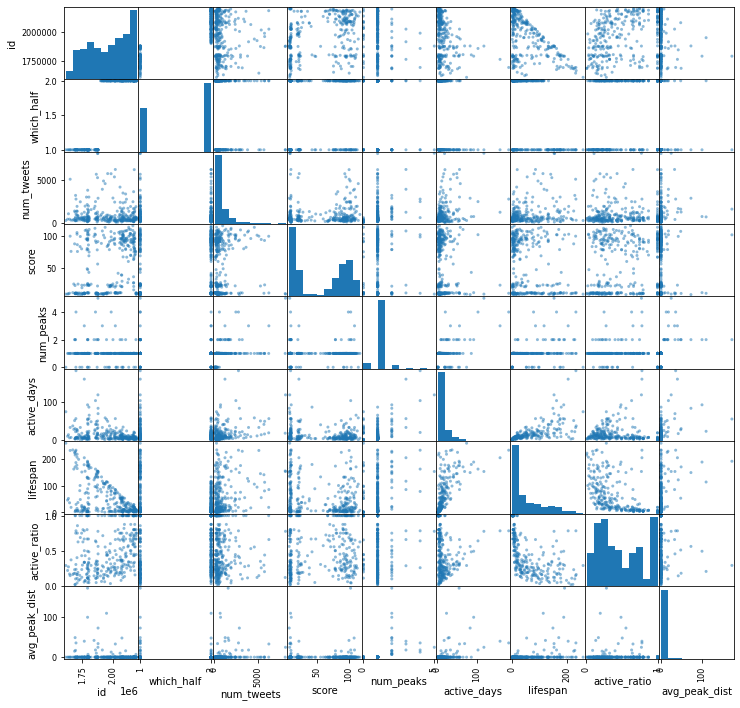

In [13]:
import seaborn as sns
pd.plotting.scatter_matrix(article_feature_df[article_feature_df.num_tweets < 10000], figsize = [12,12]);